# Airbus Ship Detection Challenge late submission notebook

## Section 1. Image dataset EDA and bounding boxes preprocessing 

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from rasterio import features
from shapely.geometry import MultiPoint

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorboard

from skimage.io import imread
from PIL import Image
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

%matplotlib inline
import gc
gc.enable()

In [27]:
train_data = os.listdir('/kaggle/input/airbus-ship-detection/train_v2')
test_data = os.listdir('/kaggle/input/airbus-ship-detection/test_v2')
working_dir = '/kaggle/working/'

image_path_train = '/kaggle/input/airbus-ship-detection/train_v2'
image_path_test = '/kaggle/input/airbus-ship-detection/test_v2'
RLE_PATH = '../input/airbus-ship-detection/train_ship_segmentations_v2.csv'
submission = pd.read_csv('/kaggle/input/airbus-ship-detection/sample_submission_v2.csv')
submission.head()

,ImageId,EncodedPixels
0,00002bd58.jpg,1 2
1,00015efb6.jpg,1 2
2,00023d5fc.jpg,1 2
3,000367c13.jpg,1 2
4,0008ca6e9.jpg,1 2


In [5]:
image_ids = [file for file in os.listdir(image_path_train) if file.endswith('.jpg')]
len(image_ids)

192556

In [6]:
def encode_mask(mask, shape=(768,768)):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    s = mask.split()
    for i in range(len(s)//2):
        start = int(s[2*i]) - 1
        length = int(s[2*i+1])
        img[start:start+length] = 1
    return img.reshape(shape).T

In [7]:
rle_df = pd.read_csv(RLE_PATH)
rle_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Performing RLE conversion and obtaining bounding boxes coordinates in pixels

In [9]:
lines = []
for row in tqdm(rle_df.itertuples(), total=len(rle_df)): #
    if pd.isna(row.EncodedPixels):
        lines.append({
            "ImageId": row.ImageId,
            "EncodedPixels": np.nan,
            "xc": np.nan,
            "yc": np.nan, 
            "dx": np.nan,
            "dy": np.nan,
            "angle": np.nan
        })
        continue

    # convert RLE encoded pixels into binary mask
    mask = encode_mask(str(row.EncodedPixels), shape=(768,768))

    # vectorize mask into GeoJSON
    value = 0.0
    for polygon, value in list(features.shapes(mask)):
        if value == 1.0:
            break
    if value != 1.0:
        print('Error while vectorizing mask')

    # get oriented bounding box around shape
    coords = polygon['coordinates'][0]
    obbox = MultiPoint(coords).minimum_rotated_rectangle

    # get center of bounding box and correct for half a pixel
    xc, yc = list(obbox.centroid.coords)[0]
    xc, yc = xc - 0.5, yc - 0.5
    
    # get external coordinates of oriented rectangle
    # compute length, width and angle
    p1, p2, p3, p4, p5 = list((obbox.exterior.coords))
    dx = math.sqrt((p3[0] - p2[0])**2 + (p3[1] - p2[1])**2)
    dy = math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)
    angle = math.atan2((p3[1] - p2[1]), (p3[0] - p2[0]))
    length = max(dx, dy)
    height = min(dx, dy)
    
    # store in list
    lines.append({
        "ImageId": row.ImageId,
        "EncodedPixels": row.EncodedPixels,
        "xc": xc,
        "yc": yc, 
        "dx": dx,
        "dy": dy,
        "angle": angle
    })
    #print(lines)
    #break

# create DataFrame
obbox_df = pd.DataFrame(lines, columns=['ImageId', 'EncodedPixels', 'xc', 'yc', 'dx', 'dy', 'angle'])

100%|██████████| 231723/231723 [17:27<00:00, 221.29it/s]


Obtained data can be saved on disk as CSV to ensure ease of access during further stage of data preprocession and model training

In [10]:
obbox_df['ships'] = obbox_df['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

In [11]:
# check the resulting DataFrame
obbox_df.head()

,ImageId,EncodedPixels,xc,yc,dx,dy,angle,ships
0,00003e153.jpg,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0001124c7.jpg,NaN,NaN,NaN,NaN,NaN,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,395.367761,482.503889,34.044102,103.808051,-1.600200,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,479.960000,296.720000,9.000000,24.600000,2.214297,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,75.500000,381.000000,18.000000,9.000000,3.141593,1


In [12]:
# save the resulting dataframe on disk as a CSV
obbox_df.to_csv("airbus_ship_train_obbox.csv", 
                  sep=',', na_rep='', float_format="%.2f", header=True, index=False)

In [12]:
# access to file as a new dataset
BOXES_PATH = '/kaggle/input/bbox-cvs/airbus_ship_train_obbox.csv'

box_df = pd.read_csv(BOXES_PATH)
box_df.head()

,ImageId,EncodedPixels,xc,yc,dx,dy,angle,ships
0,00003e153.jpg,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0001124c7.jpg,NaN,NaN,NaN,NaN,NaN,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,395.37,482.50,34.04,103.81,-1.60,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,479.96,296.72,9.00,24.60,2.21,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,75.50,381.00,18.00,9.00,3.14,1


Defining functions for bounding box convertion and plotting

In [13]:
#get bounding box for a mask
def get_bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

#add padding to the bounding box
def get_bbox_p(img, padding):
    x1,x2,y1,y2 = get_bbox(img)
    lx,ly = img.shape
    x1 = max(x1-padding,0)
    x2 = min(x2+padding+1, lx-1)
    y1 = max(y1-padding,0)
    y2 = min(y2+padding+1, ly-1)
    return x1,x2,y1,y2

#convert parameters of the box for plotting
def convert_box(box):
    rot1 = math.cos(box[4])
    rot2 = math.sin(box[4])
    bx1 = box[0] - 0.5*(box[2]*rot1 - box[3]*rot2)
    bx2 = box[1] - 0.5*(box[2]*rot2 + box[3]*rot1)
    return (bx1,bx2,box[2],box[3],box[4]*180.0/math.pi)

def get_rec(box,width=1):
    b = convert_box(box)
    return patches.Rectangle((b[0],b[1]),b[2],b[3],b[4],linewidth=width,edgecolor='g',facecolor='none')

In order visually verify correctness of decoding, we define function that plotes images and respective bounding boxes.

In [14]:
#plot image, mask, zoomed image, and zoomed mask with rotating bounding boxes
def show_box(idx, padding):
    row = box_df.iloc[idx]
    name, encoding, x, y, dx, dy, rot = row.ImageId, row.EncodedPixels, \
        row.xc, row.yc, row.dx, row.dy, row.angle
    
    image = np.asarray(Image.open(os.path.join(image_path_train, name)))
        
    if pd.isna(encoding): #empty image
        plt.title(idx)
        plt.imshow(image)
        plt.axis('off')
        return 

    mask = encode_mask(encoding)
    box = (x,y,dx,dy,rot)

    fig,ax = plt.subplots(2, 2, figsize=(16, 16))
    ax[0,0].imshow(image)
    ax[0,1].imshow(mask)
    ax[0,0].add_patch(get_rec(box))
    ax[0,1].add_patch(get_rec(box))
    
    y1,y2,x1,x2 = get_bbox_p(mask,padding)
    box_c = (x-x1,y-y1,dx,dy,rot)
    ax[1,0].imshow(image[y1:y2,x1:x2,:])
    ax[1,1].imshow(mask[y1:y2,x1:x2])
    ax[1,0].add_patch(get_rec(box_c,3))
    ax[1,1].add_patch(get_rec(box_c,3))
    
    for item in ax.flatten():
        item.axis('off')

    plt.title(idx)
    plt.show()
    
    
    return image.shape

Plotting source selection

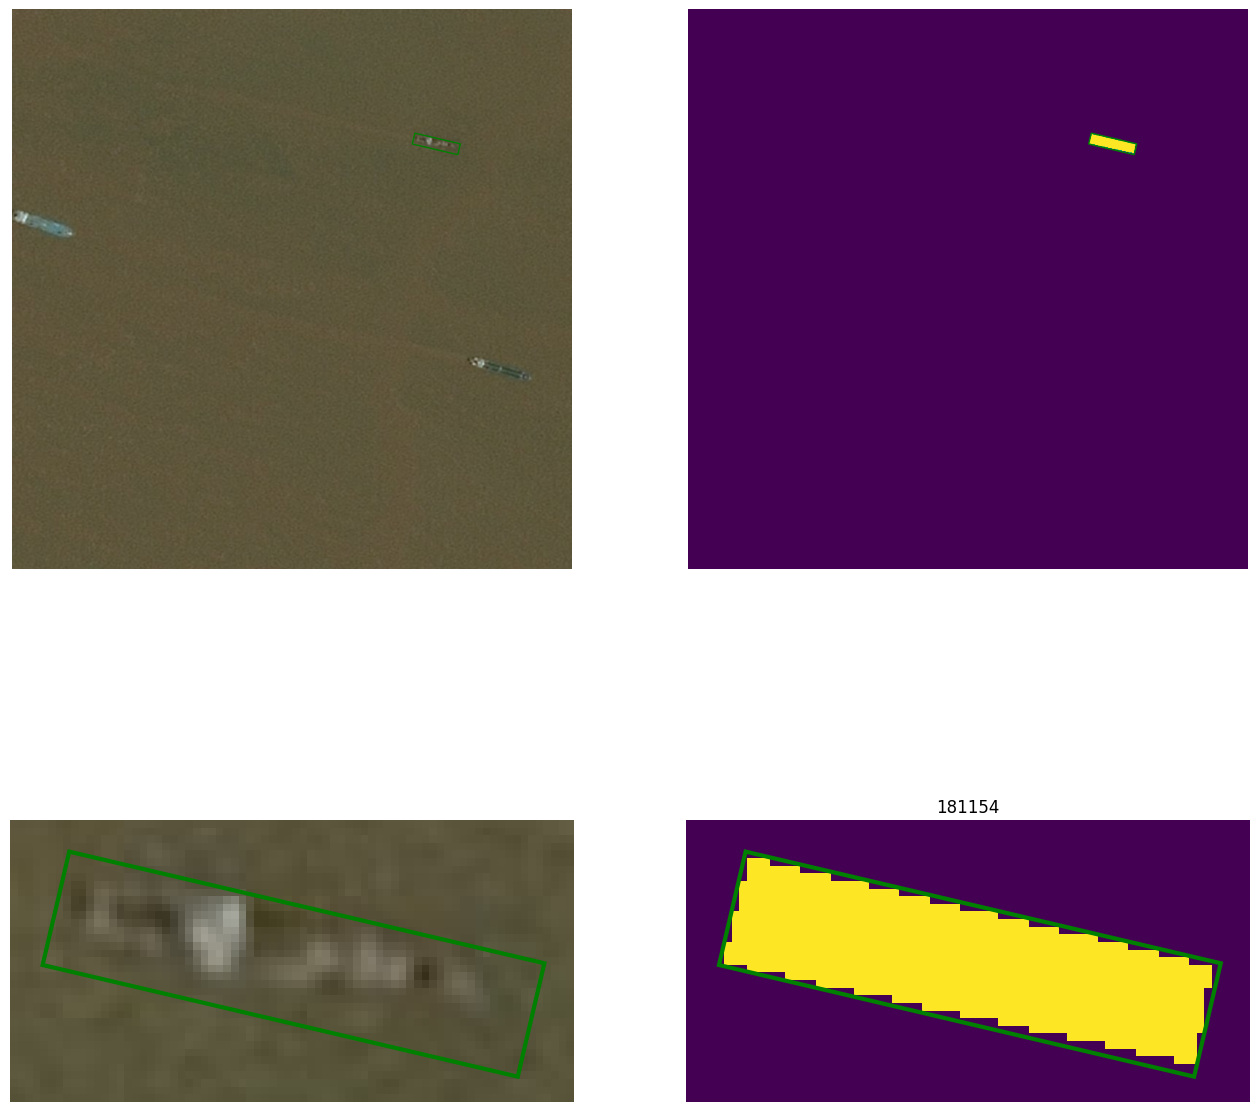

In [20]:
# select a random image
import random
#idx = random.randrange(len(box_df))
idx = 181154
image_shape = show_box(idx, 5)

Obtained values of image shape become global parameters for the rest of training process.

In [21]:
W = image_shape[0]
H = image_shape[1]
print(W, H)

768 768


The Challenge of detecting the ships in the images can be thought as a classification problem for pixels, where, for each image, we need to classify 768  ×  768 pixels in one of two classes: ship and no-ship. 
we will just present the imbalance of the classes considering a pixel-level granularity, this is, we will check how many pixels in the dataset corresponds to ships and how many to other stuff (no-ships)

Few notes before diving into the code:

The total_pixels is  768×768×n_imgs
 
The total amount of ship_pixels is encoded in the EncodedPixels: it's actually the sum of the all the pair positions of those strings.
Since we have defined a rle_to_pixels function before, we will just use it and count the amount of pixels after that transformation
The total amount of no_ship_pixels is total_pixels - ship_pixels

In [8]:
# This function transforms EncodedPixels into a list of pixels

def rle_to_pixels(rle_code):
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1:-2:2])) 
                 for pixel_position in range(start, start + length)]
    return pixels

def show_pixels_distribution(df):
    """
    Prints the amount of ship and no-ship pixels in the df
    """
    # Total images in the df
    n_images = df['ImageId'].nunique() 
    
    # Total pixels in the df
    total_pixels = n_images * 768 * 768 

    # Keep only rows with RLE boxes, transform them into list of pixels, sum the lengths of those lists
    ship_pixels = df['EncodedPixels'].dropna().apply(rle_to_pixels).str.len().sum() 

    ratio = ship_pixels / total_pixels
    print(f"Ship: {round(ratio, 3)} ({ship_pixels})")
    print(f"No ship: {round(1 - ratio, 3)} ({total_pixels - ship_pixels})")

In [23]:
show_pixels_distribution(box_df)

Ship: 0.001 (127777104)
No ship: 0.999 (113446373040)


In [19]:
unique_img = box_df
unique_img['HasShip'] = box_df['EncodedPixels'].notnull()
idx = pd.IndexSlice
df_ship_count = unique_img.groupby("ImageId").agg({'HasShip': ['first', 'sum']})
df_ship_count.columns = ['HasShip', 'TotalShips']

In [25]:
def show_df(df):
    """
    Prints and displays the ship/no-ship ratio and the ship count distribution of df
    """
    total = len(df)
    ships_count = df['HasShip'].sum()
    no_ship_count = total - ships_count
    total_ships = int(df_ship_count['TotalShips'].sum())
        
    print(f"Images: {total} \nShips:  {total_ships}")
    print(f"Images with ships:    {round(ships_count/total,2)} ({ships_count})")
    print(f"Images with no ships: {round(no_ship_count/total,2)} ({no_ship_count})")
    
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 8), gridspec_kw = {'width_ratios':[1, 3]})
    
    # Plot ship/no-ship with a bar plot
    ship_ratio = df['HasShip'].value_counts() / total
    ship_ratio = ship_ratio.rename(index={True: 'Ship', False: 'No Ship'})
    ship_ratio.plot.bar(ax=axes[0], color=['magenta', 'lime'], rot=0, title="Ship/No-ship distribution");
    
    # Plot TotalShips distribution with a bar plot
    total_ships_distribution = df.loc[df['HasShip'], 'TotalShips'].value_counts().sort_index() / ships_count
    total_ships_distribution.plot(kind='bar', ax=axes[1], rot=0, title="Total ships distribution");

Images: 192556 
Ships:  81723
Images with ships:    0.22 (42556)
Images with no ships: 0.78 (150000)


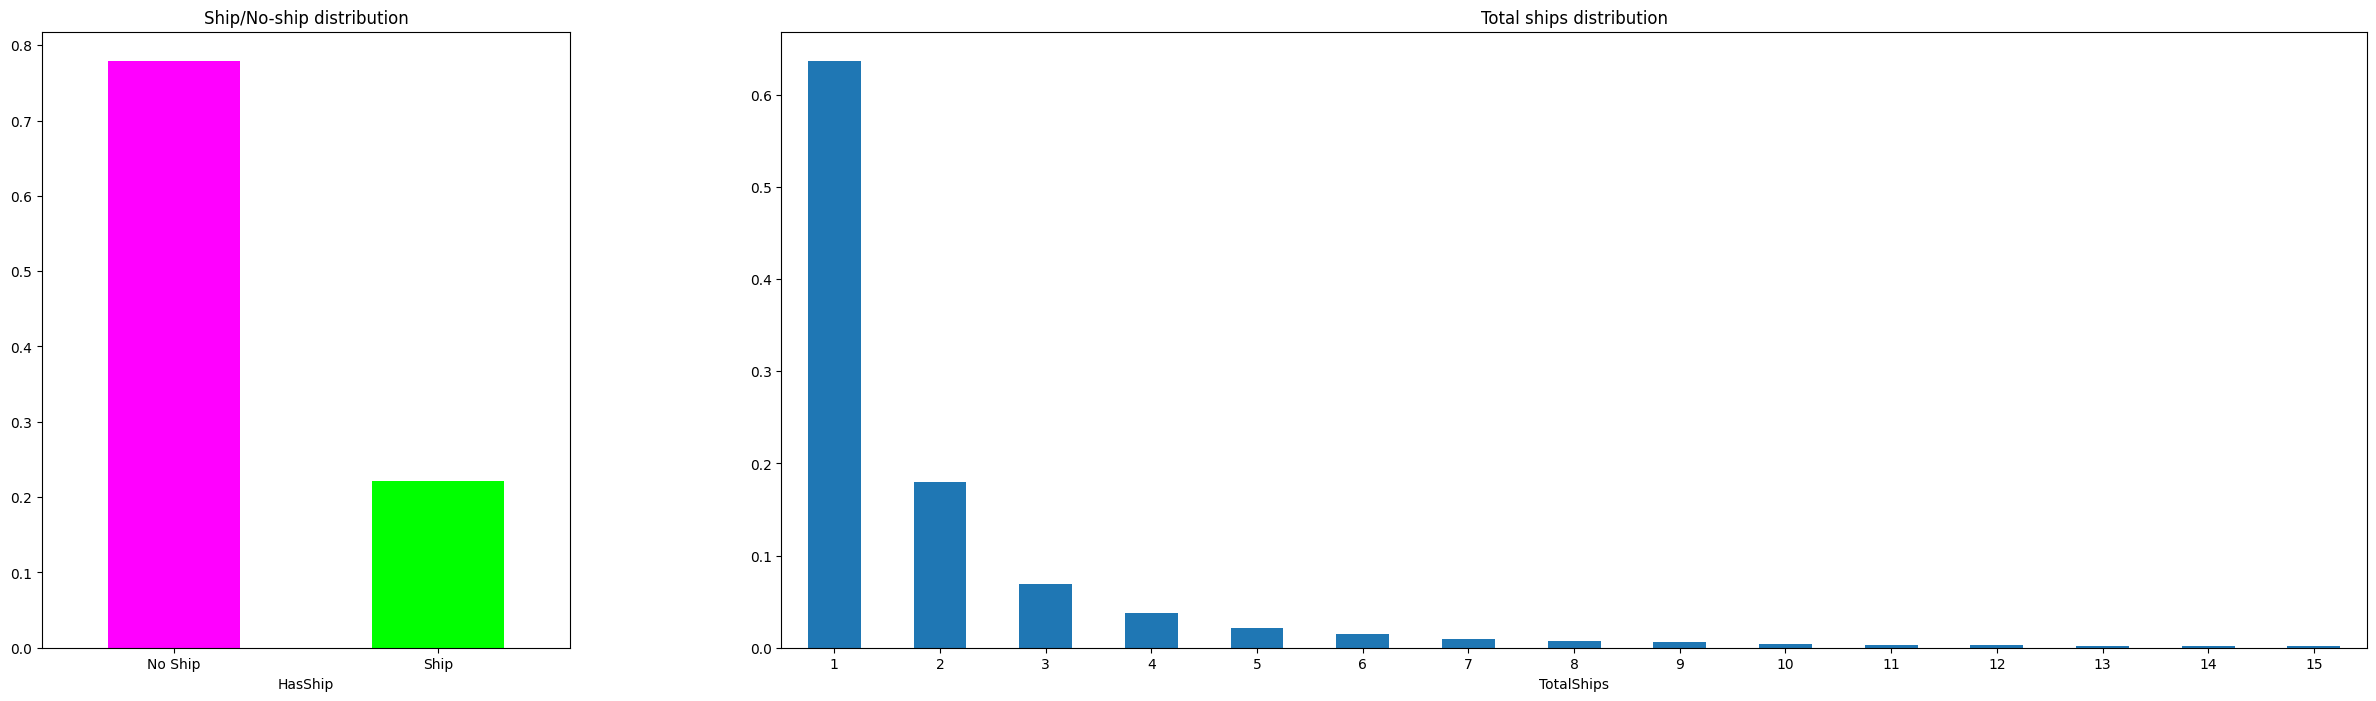

In [26]:
show_df(df_ship_count)

Due to memory limitations, in this work, we select only images containing ships, and only those with smaller or larger number of ships present.

In [20]:
total_ships_distribution = df_ship_count.loc[df_ship_count['HasShip'], 'TotalShips']
selected1 = pd.DataFrame(total_ships_distribution)[pd.DataFrame(total_ships_distribution)['TotalShips'] < 2][:100]
selected5 = pd.DataFrame(total_ships_distribution)[pd.DataFrame(total_ships_distribution)['TotalShips'] < 5][:150] 
selected10 = pd.DataFrame(total_ships_distribution)[pd.DataFrame(total_ships_distribution)['TotalShips'] > 10][:50]

In [21]:
final_selection_df = box_df[box_df["ImageId"].isin([*selected10.index, *selected5.index])]
final_selection_df.reset_index()

,index,ImageId,EncodedPixels,xc,yc,dx,dy,angle,ships,HasShip
0,2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,395.37,482.50,34.04,103.81,-1.60,1,True
1,18,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,341.40,48.80,26.39,8.50,-2.03,1,True
2,19,0002756f7.jpg,248878 1 249645 4 250413 6 251180 9 251948 10 ...,333.27,53.69,9.96,26.87,-0.48,1,True
3,22,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,457.00,138.00,25.00,19.40,-2.50,1,True
4,24,000532683.jpg,458957 14 459725 14 460493 14 461261 14 462029...,600.00,466.50,7.00,14.00,3.14,1,True
...,...,...,...,...,...,...,...,...,...,...
859,25753,1c9115b08.jpg,429430 2 430198 5 430965 8 431733 10 432500 11...,580.60,111.20,10.29,46.96,-2.03,1,True
860,25754,1c9115b08.jpg,142946 2 143712 5 144478 7 145244 10 146010 12...,195.80,85.40,8.50,33.54,-2.68,1,True
861,25755,1c9115b08.jpg,246713 2 247479 4 248245 7 249010 10 249776 12...,330.52,173.60,10.99,30.06,0.41,1,True
862,25756,1c9115b08.jpg,189889 2 190653 6 191418 10 192183 13 192947 1...,279.03,193.12,19.67,63.69,1.85,1,True


## Section 2. Training dataset preparation

Since tensorflow framework is used for model training, datasets should be prepared in the form of tensors of a respective ranks.
Training and validation images are given in the form 4th rank tensors, like T = (N, H, W, 3), 
where N is the number of images in the training dataset, H is the image height (pixels), W is the image width (pixels), 3 is the colour channels (RGB). The RGB channel values are in the [0, 255] range. 
Since models perform better with normilized inputs, channels are normilized to be in range [-1, 1] or [0, 1] as found necessary.
Training and validation bounding boxes (targets) are given in the form of 4 component vector, like Box = [x1, y1, x2, y2],
where x and y are coordinates in pixels.

In [29]:
def load_dataset(split=0.15):
    
    """ Extracting the images and bounding boxes from csv file. """
    images = []
    bboxes = []
 
    #for idx in range(1000):
    for idx in range(len(final_selection_df)):
        
        row = final_selection_df.iloc[idx]
        name, encoding, x, y, dx, dy, rot = row.ImageId, row.EncodedPixels, \
        row.xc, row.yc, row.dx, row.dy, row.angle
        if pd.isna(encoding):
           norm_bbox = np.array([0, 0, 0, 0], dtype=np.float32)
           bboxes.append(norm_bbox)
        else:
            mask = encode_mask(encoding)
            """ Bounding box """        
            y1,y2,x1,x2 = get_bbox_p(mask,0)
            bbox = [x1, y1, x2, y2]
            norm_x1 = float(x1/W)
            norm_y1 = float(y1/H)
            norm_x2 = float(x2/W)
            norm_y2 = float(y2/H)
            norm_bbox = np.array([norm_x1, norm_y1, norm_x2, norm_y2], dtype=np.float32)
            bboxes.append(norm_bbox)
            
        
        image = np.asarray(Image.open(os.path.join(image_path_train, name)), dtype = np.float32)
        #image = cv2.imread(path, cv2.IMREAD_COLOR)
        #h, w, _ = image.shape
        #image = cv2.resize(image, (W, H)) # If required, image can resized to uniform value
        image = (image - 127.5) / 127.5 ## range [-1, +1]
        #image = image / 225 ## range [0, +1]
                     
        images.append(image)
        
 
    """ Split into training and validation """
    
    train_x, valid_x = train_test_split(images, test_size=split, random_state=42)
    train_y, valid_y = train_test_split(bboxes, test_size=split, random_state=42)
    
    return (train_x, train_y), (valid_x, valid_y)

In [30]:
(train_x, train_y), (valid_x, valid_y) = load_dataset()

In [31]:
print("There are:")
print(len(train_x), 'training masks,')
print(len(valid_x), 'validation masks.')

There are:
734 training masks,
130 validation masks.


Initializing training hyperparameters

In [32]:
if __name__ == "__main__":
     """ Seeding """
     np.random.seed(42)
     tf.random.set_seed(42)
 
     """ Hyperparameters """
     batch_size = 32
     lr = 1e-4
     num_epochs = 10
    #Saving model in h5 format
     model_path = os.path.join(working_dir, "model.h5")
     csv_path = os.path.join(working_dir, "log.csv")

Using standard tensoflow function to create training and validation datasets.

In [33]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(batch_size).prefetch(10)
valid_ds = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(batch_size).prefetch(10)

Get one training tensor as an example.

In [34]:
train_dataset = train_ds.take(1)
list(train_dataset.as_numpy_iterator())

[(array([[[[-0.43529412, -0.5058824 , -0.49803922],
           [-0.3882353 , -0.4509804 , -0.46666667],
           [-0.34901962, -0.3882353 , -0.4117647 ],
           ...,
           [ 0.12941177,  0.16862746,  0.11372549],
           [ 0.09803922,  0.14509805,  0.11372549],
           [ 0.05882353,  0.12941177,  0.10588235]],
  
          [[-0.43529412, -0.5058824 , -0.49803922],
           [-0.3882353 , -0.4509804 , -0.46666667],
           [-0.34901962, -0.3882353 , -0.41960785],
           ...,
           [ 0.11372549,  0.13725491,  0.06666667],
           [ 0.08235294,  0.12156863,  0.06666667],
           [ 0.05098039,  0.10588235,  0.05098039]],
  
          [[-0.41960785, -0.48235294, -0.49803922],
           [-0.3882353 , -0.4509804 , -0.46666667],
           [-0.35686275, -0.39607844, -0.42745098],
           ...,
           [ 0.00392157,  0.01176471, -0.09803922],
           [ 0.01176471,  0.02745098, -0.07450981],
           [ 0.01176471,  0.03529412, -0.05098039]],
  
    

### Configure the dataset for performance
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training model. If r dataset is too large to fit into memory, one can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.




In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Section 3. MobilNetV2 image classification model.
Since it is a common approach to utilize transfer learning while developing ML models, section 3 contains an example of it.

MobileNetV2 is a convolutional neural network architecture that seeks to perform well on mobile devices. It is based on an inverted residual structure where the residual connections are between the bottleneck layers. The intermediate expansion layer uses lightweight depthwise convolutions to filter features as a source of non-linearity. As a whole, the architecture of MobileNetV2 contains the initial fully convolution layer with 32 filters, followed by 19 residual bottleneck layers.

In [39]:
def build_model(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)
 
    """ Backbone """
    backbone = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs,
        alpha=1.0
    )
    backbone.trainable = False
    # backbone.summary()
 
    """ Detection Head """
    x = backbone.output
    x = L.Conv2D(256, kernel_size=1, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.GlobalAveragePooling2D()(x)
    x = L.Dropout(0.5)(x)
    x = L.Dense(4, activation="sigmoid")(x)
 
    """ Model """
    model = Model(inputs, x)
    return model

Building the model

In [40]:
""" Model """
model = build_model((H, W, 3))
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr)
)

9406464/9406464 [==============================] - 0s 0us/step


Defining callbacks for training performance evaluation. Tensorboard is used for a better visualization of training process.

In [3]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [42]:
# Define the Keras TensorBoard callback.
from datetime import datetime
logdir = working_dir + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)
#Standard callbacks
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path, append=True),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    tensorboard_callback
]

Training the model

In [43]:
model.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=valid_ds,
    callbacks=callbacks
)

Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 0.7460
Epoch 1: val_loss improved from inf to 0.68875, saving model to /kaggle/working/model.h5
23/23 [==============================] - 246s 11s/step - loss: 0.7460 - val_loss: 0.6887 - lr: 1.0000e-04
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 0.7207
Epoch 2: val_loss improved from 0.68875 to 0.67102, saving model to /kaggle/working/model.h5
23/23 [==============================] - 233s 10s/step - loss: 0.7207 - val_loss: 0.6710 - lr: 1.0000e-04
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 0.7125
Epoch 3: val_loss improved from 0.67102 to 0.66328, saving model to /kaggle/working/model.h5
23/23 [==============================] - 231s 10s/step - loss: 0.7125 - val_loss: 0.6633 - lr: 1.0000e-04
Epoch 4/10
23/23 [==============================] - ETA: 0s - loss: 0.7028
Epoch 4: val_loss improved from 0.66328 to 0.65768, saving model to /kaggle/working/model.h5
23/23 [=======

In [16]:
%tensorboard --logdir 'C:\Users\msste\OneDrive\Coding\DA\Winstars.AI\0240224-224705' --port 6006

## Section 4. A custom training model
A custom training model is build to compare performance of pretrained model from Sec. 3 and provide few extra hypermarameters from image augmentation layer.

It is a good idea to add image augmentation layer to an image classification model to 

In [35]:
data_augmentation = tf.keras.Sequential([
  L.RandomFlip("horizontal"),
  L.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(
    height_factor = 0.25,
    width_factor = 0.15,
    fill_mode = 'reflect',
    interpolation = 'bilinear',
    seed = None,
    fill_value=0.0),
  tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

In [36]:
custom_model = tf.keras.Sequential([
  data_augmentation,
  
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
   
  tf.keras.layers.Dense(4, activation="sigmoid")
])

Building the model

In [37]:
custom_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=['accuracy'])

custom_model.build((None, H, W, 3))

Training the model

In [ ]:
custom_model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=10,
  callbacks=callbacks
)

Epoch 1/10


## Section 5. Model prediction evaluation

Loading the model

In [19]:
model = tf.keras.models.load_model(os.path.join( os.getcwd(), "model.h5"))

In [10]:
def cal_iou(y_true, y_pred):
    x1 = max(y_true[0], y_pred[0])
    y1 = max(y_true[1], y_pred[1])
    x2 = min(y_true[2], y_pred[2])
    y2 = min(y_true[3], y_pred[3])
 
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
 
    true_area = (y_true[2] - y_true[0] + 1) * (y_true[3] - y_true[1] + 1)
    bbox_area = (y_pred[2] - y_pred[0] + 1) * (y_pred[3] - y_pred[1] + 1)
 
    iou = intersection_area / float(true_area + bbox_area - intersection_area)
    return iou

In [39]:
mean_iou = []
images = []
true_bbox = []
 
for idx in range(len(final_selection_df)):
   row = final_selection_df.iloc[idx]
   name, encoding, x, y, dx, dy, rot = row.ImageId, row.EncodedPixels, \
                                   row.xc, row.yc, row.dx, row.dy, row.angle
   mask = encode_mask(encoding)
   """ Bounding box """        
   true_y1, true_y2, true_x1, true_x2 = get_bbox_p(mask,0)
                 
   """ Reading the image """
   image = np.asarray(cv2.imread(os.path.join(image_path_train, name), cv2.IMREAD_COLOR), dtype = np.float32)
   #/image = cv2.resize(image, (W, H))
   image = (image - 127.5) / 127.5
   #image = image / 255  
   x = np.expand_dims(image, axis=0)
   pred_bbox = model.predict(x)
   """ True bounding box """
   true_bbox = [true_x1, true_y1, true_x2, true_y2]
   """ Rescale the bbox points. """
   
   pred_x1 = int(pred_bbox[0][0] * image.shape[1])
   pred_y1 = int(pred_bbox[0][1] * image.shape[0])
   pred_x2 = int(pred_bbox[0][2] * image.shape[1])
   pred_y2 = int(pred_bbox[0][3] * image.shape[0])
   """ Calculate IoU """
   iou = cal_iou(true_bbox, [pred_x1, pred_y1, pred_x2, pred_y2])
   mean_iou.append(iou)
   """ Plot them on image """
   image = cv2.rectangle(image, (true_x1, true_y1), (true_x2, true_y2), (255, 0, 0), 10) ## BLUE
   image = cv2.rectangle(image, (pred_x1, pred_y1), (pred_x2, pred_y2), (0, 0, 255), 10) ## RED
   x = int(image.shape[1] * 0.05)
   y = int(image.shape[0] * 0.05)
   font_size = int(image.shape[0] * 0.001)
   cv2.putText(image, f"IoU: {iou:.4f}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 0, 0), 3)
 
    #""" Saving the image """
    #cv2.imwrite(f"results/{name}", image)

1/1 [==============================] - 0s 234ms/step


In [40]:
""" Mean IoU """
score = np.mean(mean_iou, axis=0)
print(f"Mean IoU: {score:.4f}")

Mean IoU: 0.0009


Converting trained model to TFLite format which is optimized for ML modes inference.

In [20]:
model_path = os.getcwd()
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Winstars.AI\assets


INFO:tensorflow:Assets written to: C:\Users\msste\OneDrive\Coding\DA\Winstars.AI\assets


In [21]:
# Convert the model using TFLiteConverter
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
tflite_model = converter.convert()
with open('ASD_model.tflite', 'wb') as f:
  f.write(tflite_model)

# Conclusions


Due to large memory consumption, loading full imbalanced should be avoided.
A good feature distribution selected dataset is advisable to be used for training.
Despite validation loss was reducing every epoch, it would not less than 100 epochs to complete training as per industry standard.

## References
1. Kaggle notebook:
https://www.kaggle.com/julian3833/2-understanding-and-plotting-rle-bounding-boxes
2. Kaggle notebook: https://www.kaggle.com/code/julian3833/3-basic-exploratory-analysis/notebook
3. Simple Object Detection with Bounding Box Regression in TensorFlow:
https://idiotdeveloper.com/simple-object-detection-with-bounding-box-regression-in-tensorflow/